# Use LayoutParser to load and visualize COCO layout annotations

## Preparation

In this notebook, I will illustrate how to use LayoutParser to load and visualize the layout annotation in the COCO format. 

Before starting, please remember to download PubLayNet annotations and images from their [website](https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/PubLayNet.html) (let's just use the validation set for now as the training set is very large). And let's put all extracted files in the `data/publaynet/annotations` and `data/publaynet/val` folder. 

And we need to install an additional library for conveniently handling the COCO data format:
```bash
pip install pycocotools
```

OK - Let's get on the code: 

## Loading and visualizing layouts using Layout-Parser

In [1]:
from pycocotools.coco import COCO
import layoutparser as lp
import random 
import cv2

In [2]:
def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List): 
            a list of coco annotaions for the current image 
        coco (`optional`, defaults to `False`):  
            COCO annotation object instance. If set, this function will 
            convert the loaded annotation category ids to category names 
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )
    
    return layout 

The `load_coco_annotations` function will help convert COCO annotations into the layoutparser objects. 

In [5]:
COCO_ANNO_PATH = 'data/publaynet/annotations/val.json'
COCO_IMG_PATH  = 'data/publaynet/val'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=1.76s)
creating index...
index created!


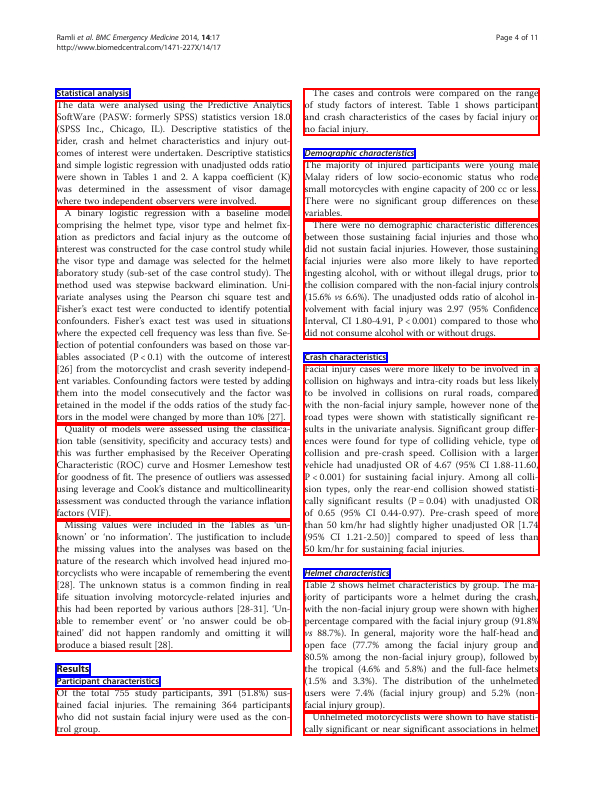

In [10]:
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'purple',
    'figure': 'pink',
}


# for image_id in random.sample(coco.imgs.keys(), 1):
for image_id in random.sample(list(coco.imgs.keys()), 1):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))
    
    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)
    
    viz = lp.draw_box(image, layout, color_map=color_map)
    display(viz) # show the results 

You could add more information in the visualization. 

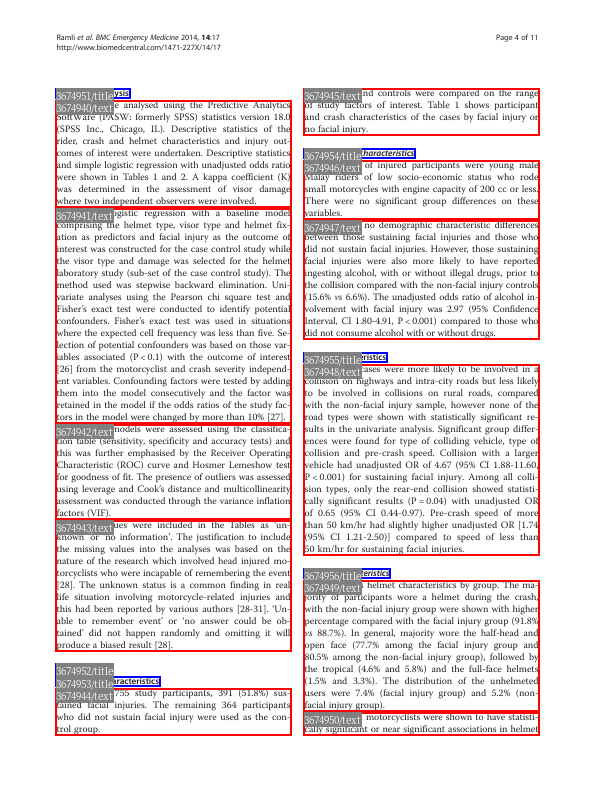

In [11]:
lp.draw_box(image, 
              [b.set(id=f'{b.id}/{b.type}') for b in layout],
              color_map=color_map,
              show_element_id=True, id_font_size=10, 
              id_text_background_color='grey',
              id_text_color='white')

## Model Predictions on loaded data

We could also check how the trained layout model performs on the input image. Following this [instruction](https://github.com/Layout-Parser/layout-parser/blob/main/examples/Deep%20Layout%20Parsing.ipynb), we could conveniently load a layout prediction model and run predictions on the existing image. 

In [12]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "text", 1: "title", 2: "list", 3:"table", 4:"figure"})

/home/chris/miniconda3/envs/layoutparser/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.yml?dl=1: 8.19kB [00:02, 3.68kB/s]
model_final.pth?dl=1: 330MB [00:16, 19.5MB/s]                               
/home/chris/miniconda3/envs/layoutparser/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbi

In [13]:
layout_predicted = model.detect(image)

/home/chris/miniconda3/envs/layoutparser/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


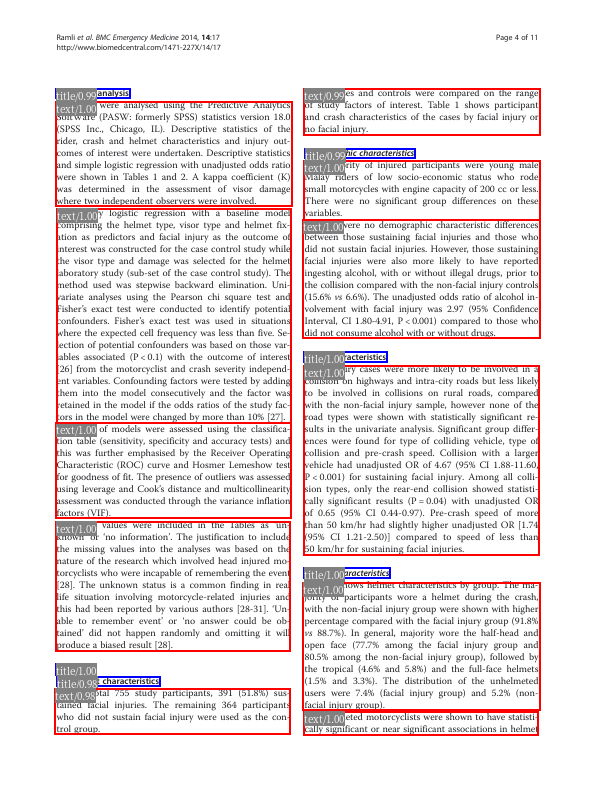

In [14]:
lp.draw_box(image, 
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10, 
              id_text_background_color='grey',
              id_text_color='white')